In [49]:
from keql_tools import Kernels
from keql_tools.KernelTools import *
import jax.numpy as jnp
from jax import grad
import jax
import matplotlib.pyplot as plt
jax.config.update("jax_enable_x64",True)
from jax import vmap

In [80]:
n = 51
full_grid = jnp.linspace(-1,1,n)
interior_grid = full_grid[1:-1]
X,Y = jnp.meshgrid(*([interior_grid]*2))
interior_points = jnp.vstack([X.flatten(),Y.flatten()]).T


bottom = jnp.vstack([full_grid,-1*jnp.ones(n)]).T
top = jnp.vstack([full_grid,jnp.ones(n)]).T

left = jnp.vstack([-1*jnp.ones(n-2),interior_grid]).T
right = jnp.vstack([jnp.ones(n-2),interior_grid]).T

hor_points = jnp.vstack([bottom,top])
vert_points = jnp.vstack([left,right])

In [81]:
def M(x):
    return jnp.exp(-0.5*(jnp.sum(x**2)))

def P(k,index):
    def k_over_M(*args):
            return k(*args)/M(args[index])

    def Mgrad(*args):
         return M(args[index]) * jax.grad(k_over_M,argnums = index)(*args)
    def Pk(*args):
        return jnp.trace(jax.jacfwd(Mgrad)(*args))
    return Pk        

In [82]:
from argparse import ArgumentDefaultsHelpFormatter
from Kernels import get_gaussianRBF


k = get_gaussianRBF(0.25)

def BC_hor(k,index):
    def kM(*args):
        return k(*args)/M(args[index])
    def neumann_op_k(*args):
        return jnp.dot(jax.grad(kM,argnums=index)(*args),jnp.array([0,1.]))
    return neumann_op_k

def BC_vert(k,index):
    def kM(*args):
        return k(*args)/M(args[index])
    def neumann_op_k(*args):
        return jnp.dot(jax.grad(kM,argnums=index)(*args),jnp.array([1.,0]))
    return neumann_op_k

h = 0.1
def IminP(k,index):
    def op(*args):
        return k(*args) - h * P(k,index)(*args)
    return op

operators = [IminP,BC_hor,BC_vert]
point_blocks = [interior_points,hor_points,vert_points]
n_boundary = len(hor_points) + len(vert_points)
n_interior = len(interior_points)

Kphiphi_blocks = [
    [make_block(k,L,R)(left_points,right_points) for R,right_points in zip(operators,point_blocks)] for L,left_points in zip(operators,point_blocks)
]

Kphiphi = jnp.block(Kphiphi_blocks)

2024-09-04 17:20:40.278030: W external/xla/xla/tsl/framework/bfc_allocator.cc:482] Allocator (GPU_0_bfc) ran out of memory trying to allocate 351.86MiB (rounded to 368947456)requested by op 
2024-09-04 17:20:40.278164: W external/xla/xla/tsl/framework/bfc_allocator.cc:494] ********************x*******************************_*******************************__******_____***
E0904 17:20:40.278180 1436121 pjrt_stream_executor_client.cc:2985] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 368947264 bytes.


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 368947264 bytes.

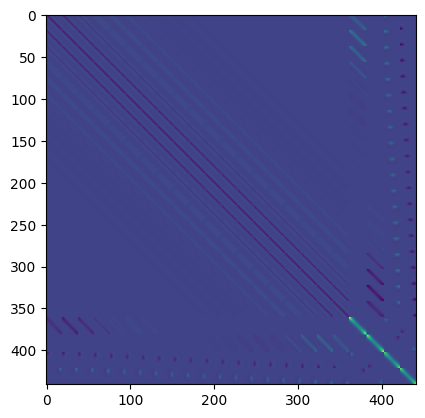

In [65]:
plt.imshow(jnp.block(Kphiphi_blocks))

In [67]:
def f(x,t):
    bottom = 2*(1-jnp.exp(-2*t))
    return (1/(jnp.pi*bottom)) * jnp.exp(-(jnp.sum(x**2)/bottom))

rhs = jnp.hstack([jax.vmap(f,in_axes = (0,None))(interior_points,0.1),jnp.zeros(n_boundary)])    

In [71]:
alpha = jnp.linalg.solve(Kphiphi + 1e-8 * diagpart(Kphiphi),rhs)

In [73]:
Kxphi = jnp.hstack([make_block(k,eval_k,operator)(interior_points,points) for operator,points in zip(operators,point_blocks)])

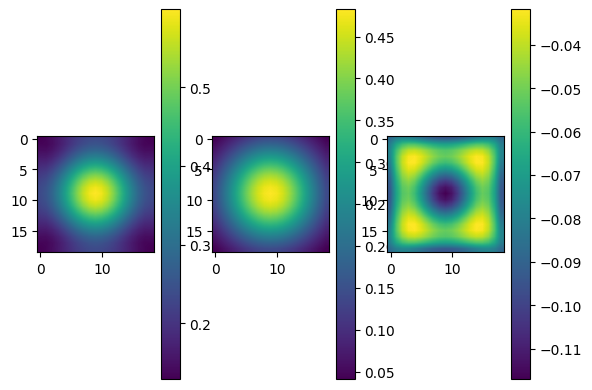

In [79]:
plt.subplot(1,3,1)
computed = (Kxphi@alpha).reshape(n-2,n-2)
plt.imshow(computed,interpolation = 'bilinear') 
plt.colorbar()
plt.subplot(1,3,2)
true = jax.vmap(f,in_axes = (0,None))(interior_points,0.2).reshape(n-2,n-2)
plt.imshow(true,interpolation = 'bilinear') 
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(true - computed,interpolation = 'bilinear') 
plt.colorbar()
plt.show()

